#Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision

# Function for balanced splitting
def __balance_val_split(dataset, val_split=0.):
    targets = np.array(dataset.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        test_size=val_split,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    val_dataset = Subset(dataset, indices=val_indices)
    return train_dataset, val_dataset

# Set the seed for reproducibility
torch.manual_seed(42)

# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download CIFAR-10 dataset
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split the dataset into training and validation sets (10% for validation)
train_dataset, val_dataset = __balance_val_split(cifar_dataset, val_split=0.1)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Download the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


100%|██████████| 170498071/170498071 [00:13<00:00, 12658362.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Layer by layer

In [2]:
import torch.nn as nn

# Define the VGG11 model with the first block and two fully connected layers
class VGG11L1(nn.Module):
    def __init__(self):
        super(VGG11L1, self).__init__()

        # First Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Assuming input image size is 32x32 after the first block
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for CIFAR-10

    def forward(self, x):
        # First Block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# Initialize the model, optimizer, and loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VGG11L1().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 1.5164, Validation Loss: 1.3523, Validation Accuracy: 52.34%
Epoch 2/10, Train Loss: 1.2128, Validation Loss: 1.1695, Validation Accuracy: 59.38%
Epoch 3/10, Train Loss: 1.1024, Validation Loss: 1.2282, Validation Accuracy: 57.10%
Epoch 4/10, Train Loss: 1.0419, Validation Loss: 1.0748, Validation Accuracy: 62.74%
Epoch 5/10, Train Loss: 0.9913, Validation Loss: 1.0640, Validation Accuracy: 63.70%
Epoch 6/10, Train Loss: 0.9600, Validation Loss: 1.0725, Validation Accuracy: 63.88%
Epoch 7/10, Train Loss: 0.9261, Validation Loss: 1.0490, Validation Accuracy: 64.14%
Epoch 8/10, Train Loss: 0.9013, Validation Loss: 1.0314, Validation Accuracy: 65.32%
Epoch 9/10, Train Loss: 0.8853, Validation Loss: 1.0291, Validation Accuracy: 65.02%
Epoch 10/10, Train Loss: 0.8650, Validation Loss: 1.0639, Validation Accuracy: 64.38%


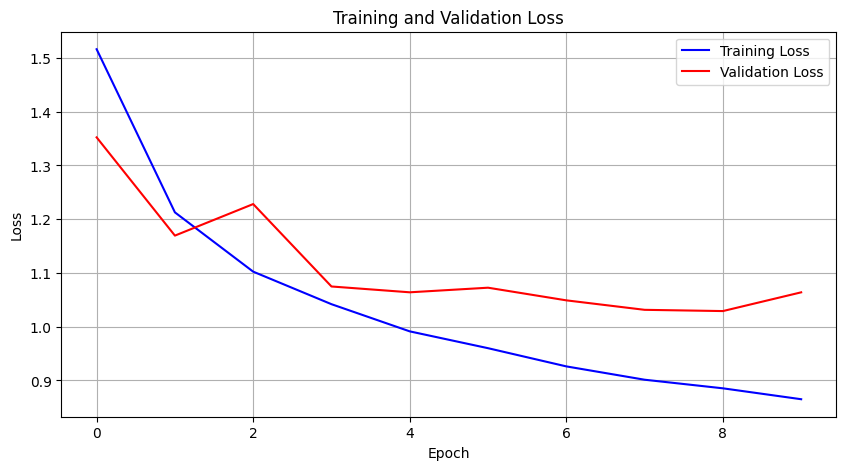

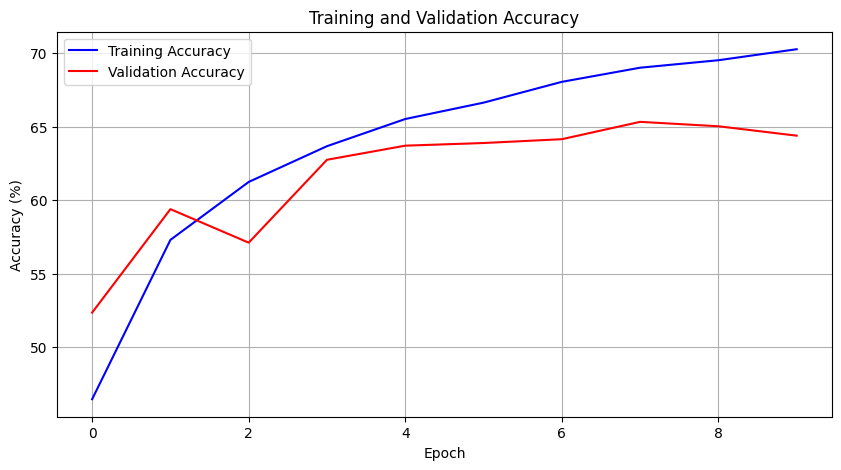

In [4]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

# Save the model weights for future use
# Save only the weights of Block 1
block1_weights = {
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var
}

torch.save(block1_weights, "first_block_weights.pth")


layer2

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with both blocks and fully connected layers at the end
class VGG11L2(nn.Module):
    def __init__(self):
        super(VGG11L2, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Assuming input size is 16x16 after both blocks
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for CIFAR-10

    def load_block1_weights(self, weights_path):
        block1_weights = torch.load(weights_path)
        self.conv1.load_state_dict(block1_weights)
    def load_block1_weights(self, weights_path):
        block1_weights = torch.load(weights_path)
        # Create a new state dictionary for Block 1
        new_block1_weights = {}
        for key in block1_weights.keys():
            new_key = key.replace("conv1.", "conv1.")
            new_block1_weights[new_key] = block1_weights[key]

        # Load the modified state dictionary
        self.conv1.load_state_dict(new_block1_weights, strict=False)


    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11L2().to(device)

# Load weights for Block 1 and freeze it
model.load_block1_weights("first_block_weights.pth")
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.bn1.parameters():
    param.requires_grad = True

# Define optimizer and criterion for Block 2
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [6]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 1.3369, Validation Loss: 1.1031, Validation Accuracy: 61.74%
Epoch 2/10, Train Loss: 1.0096, Validation Loss: 1.0049, Validation Accuracy: 64.36%
Epoch 3/10, Train Loss: 0.9091, Validation Loss: 0.9708, Validation Accuracy: 66.78%
Epoch 4/10, Train Loss: 0.8500, Validation Loss: 0.9472, Validation Accuracy: 67.34%
Epoch 5/10, Train Loss: 0.8015, Validation Loss: 0.8986, Validation Accuracy: 69.08%
Epoch 6/10, Train Loss: 0.7679, Validation Loss: 0.9105, Validation Accuracy: 69.26%
Epoch 7/10, Train Loss: 0.7346, Validation Loss: 0.9598, Validation Accuracy: 68.26%
Epoch 8/10, Train Loss: 0.6938, Validation Loss: 0.7893, Validation Accuracy: 73.72%
Epoch 9/10, Train Loss: 0.6636, Validation Loss: 0.8890, Validation Accuracy: 70.10%
Epoch 10/10, Train Loss: 0.6347, Validation Loss: 0.8576, Validation Accuracy: 70.78%


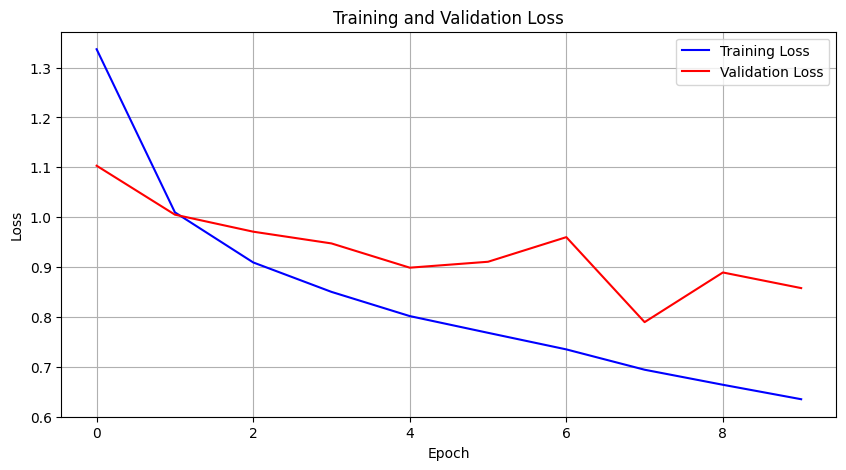

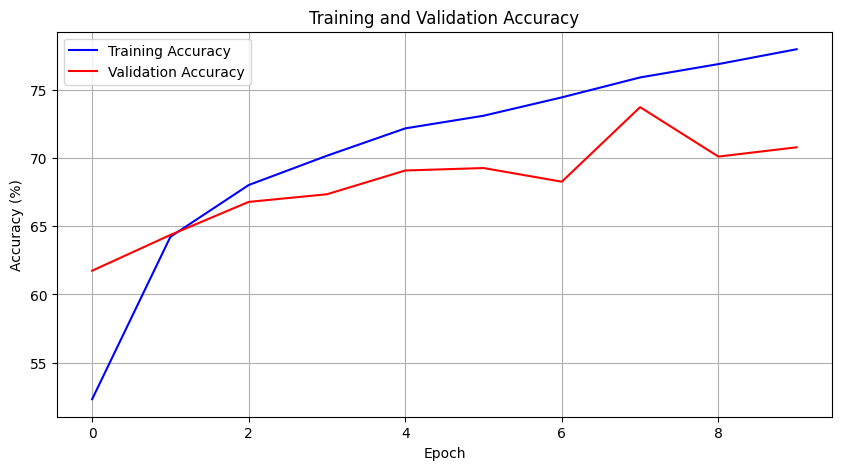

In [7]:

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Save the model weights for future use
# Save only the weights of Block 1
# Create a combined dictionary containing weights of Block 1 and Block 2
combined_weights = {
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, "combined_block1_block2_weights.pth")



Layer 3

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class VGG11L3(nn.Module):
    def __init__(self):
        super(VGG11L3, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3 (newly added)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjusted based on the output size of Block 3
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for CIFAR-10

    def load_block2_weights(self, weights_path):
        block2_weights = torch.load(weights_path)
        new_block2_weights = {}
        for key in block2_weights.keys():
            new_key = key.replace("conv2.", "conv2.")
            new_block2_weights[new_key] = block2_weights[key]
        self.conv2.load_state_dict(new_block2_weights, strict=False)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11L3 model
model = VGG11L3().to(device)

# Load weights for Block 2 and freeze it
model.load_block2_weights("combined_block1_block2_weights.pth")
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.bn2.parameters():
    param.requires_grad = True

# Freeze Block 1
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.bn1.parameters():
    param.requires_grad = True

# Define optimizer and criterion for Block 3
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [9]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 1.2313, Validation Loss: 1.1600, Validation Accuracy: 58.96%
Epoch 2/10, Train Loss: 0.8650, Validation Loss: 0.9059, Validation Accuracy: 68.96%
Epoch 3/10, Train Loss: 0.7542, Validation Loss: 0.9124, Validation Accuracy: 68.58%
Epoch 4/10, Train Loss: 0.6683, Validation Loss: 0.9365, Validation Accuracy: 69.32%
Epoch 5/10, Train Loss: 0.6032, Validation Loss: 0.7566, Validation Accuracy: 74.88%
Epoch 6/10, Train Loss: 0.5593, Validation Loss: 0.7583, Validation Accuracy: 74.48%
Epoch 7/10, Train Loss: 0.5068, Validation Loss: 0.6990, Validation Accuracy: 76.82%
Epoch 8/10, Train Loss: 0.4675, Validation Loss: 0.6821, Validation Accuracy: 77.72%
Epoch 9/10, Train Loss: 0.4324, Validation Loss: 0.6718, Validation Accuracy: 77.94%
Epoch 10/10, Train Loss: 0.4078, Validation Loss: 0.8414, Validation Accuracy: 74.66%


In [10]:
# Create a combined dictionary containing weights of Block 1, Block 2, and Block 3
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, "combined_block1_block2_block3_weights.pth")


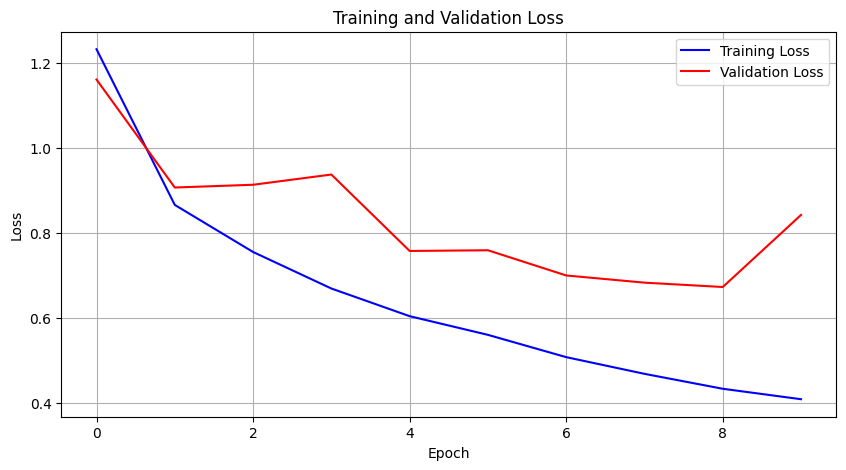

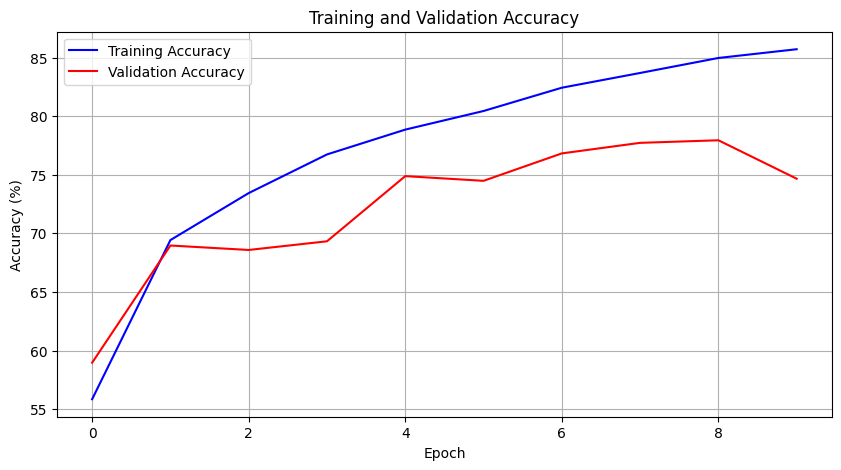

In [11]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

Layer 4

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))  # Removed maxpool3
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

    def load_combined_weights(self, weights_path):
        # Load the saved combined weights for Block 1, Block 2, and Block 3
        combined_weights = torch.load(weights_path)

        # Load the modified weights into the respective blocks
        self.load_state_dict(combined_weights, strict=False)

# Create an instance of the VGG11 model
model = VGG11().to(device)

# Path to the saved combined weights of Block 1, Block 2, and Block 3
weights_path = "combined_block1_block2_block3_weights.pth"

# Load the combined weights into the model
model.load_combined_weights(weights_path)

# Freeze Block 1, Block 2, and Block 3
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [13]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.7707, Validation Loss: 0.8044, Validation Accuracy: 73.58%
Epoch 2/10, Train Loss: 0.5310, Validation Loss: 0.6656, Validation Accuracy: 78.22%
Epoch 3/10, Train Loss: 0.4275, Validation Loss: 0.7080, Validation Accuracy: 77.30%
Epoch 4/10, Train Loss: 0.3783, Validation Loss: 0.7082, Validation Accuracy: 78.10%
Epoch 5/10, Train Loss: 0.3436, Validation Loss: 0.7104, Validation Accuracy: 77.84%
Epoch 6/10, Train Loss: 0.2936, Validation Loss: 0.6314, Validation Accuracy: 80.70%
Epoch 7/10, Train Loss: 0.2639, Validation Loss: 0.6272, Validation Accuracy: 80.94%
Epoch 8/10, Train Loss: 0.2206, Validation Loss: 0.6119, Validation Accuracy: 82.46%
Epoch 9/10, Train Loss: 0.2105, Validation Loss: 0.7367, Validation Accuracy: 80.04%
Epoch 10/10, Train Loss: 0.1741, Validation Loss: 0.6259, Validation Accuracy: 82.70%


In [14]:
import torch

# Path to save the combined weights of Block 1, Block 2, Block 3, and Block 4
weights_path = "combined_block1_block2_block3_block4_weights.pth"

# Dictionary to store the combined weights
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var
}

# Save the combined weights to a file
torch.save(combined_weights, weights_path)


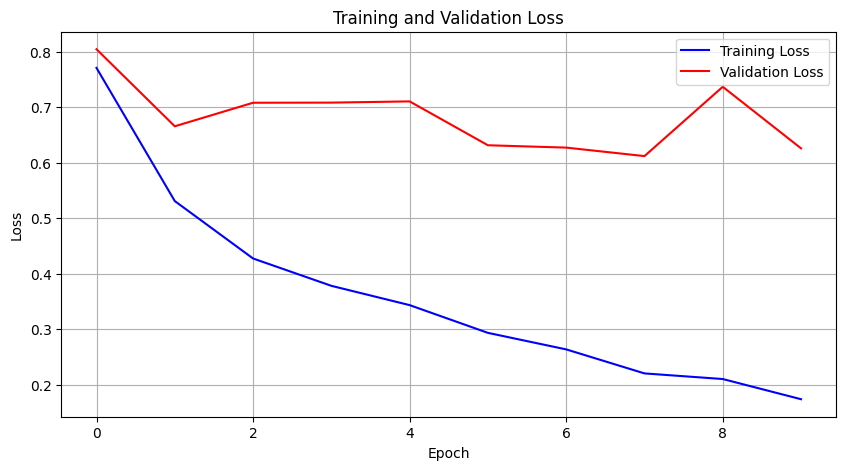

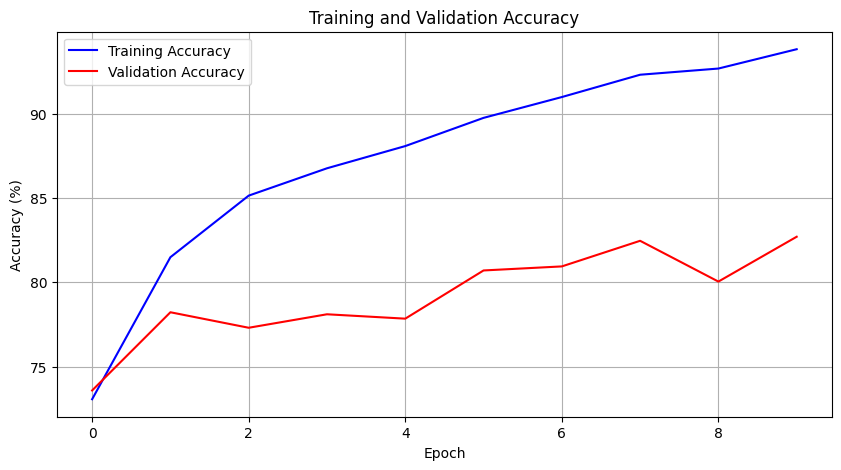

In [15]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

#layer 5

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision

# Function for balanced splitting
def __balance_val_split(dataset, val_split=0.):
    targets = np.array(dataset.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        test_size=val_split,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    val_dataset = Subset(dataset, indices=val_indices)
    return train_dataset, val_dataset

# Set the seed for reproducibility
torch.manual_seed(42)

# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download CIFAR-10 dataset
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split the dataset into training and validation sets (10% for validation)
train_dataset, val_dataset = __balance_val_split(cifar_dataset, val_split=0.1)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Download the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
import torch.nn as nn
import torch.optim as optim
import torch

class VGG11l5(nn.Module):
    def __init__(self):
        super(VGG11l5, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VGG11l5().to(device)

# Path to the saved combined weights of Block 1, Block 2, Block 3, and Block 4
weights_path = "combined_block1_block2_block3_block4_weights.pth"

# Load the combined weights into the model
combined_weights = torch.load(weights_path)
model.load_state_dict(combined_weights, strict=False)

# Freeze Block 1, Block 2, Block 3, and Block 4
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True
for param in model.conv4.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [18]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.6938, Validation Loss: 0.6126, Validation Accuracy: 78.64%
Epoch 2/10, Train Loss: 0.4922, Validation Loss: 0.7106, Validation Accuracy: 76.10%
Epoch 3/10, Train Loss: 0.4494, Validation Loss: 0.5410, Validation Accuracy: 81.28%
Epoch 4/10, Train Loss: 0.4235, Validation Loss: 0.6515, Validation Accuracy: 78.16%
Epoch 5/10, Train Loss: 0.3905, Validation Loss: 0.5400, Validation Accuracy: 81.48%
Epoch 6/10, Train Loss: 0.3605, Validation Loss: 0.6115, Validation Accuracy: 79.50%
Epoch 7/10, Train Loss: 0.3512, Validation Loss: 0.5045, Validation Accuracy: 83.62%
Epoch 8/10, Train Loss: 0.3250, Validation Loss: 0.5333, Validation Accuracy: 82.60%
Epoch 9/10, Train Loss: 0.3066, Validation Loss: 0.5016, Validation Accuracy: 83.10%
Epoch 10/10, Train Loss: 0.2914, Validation Loss: 0.4716, Validation Accuracy: 84.52%


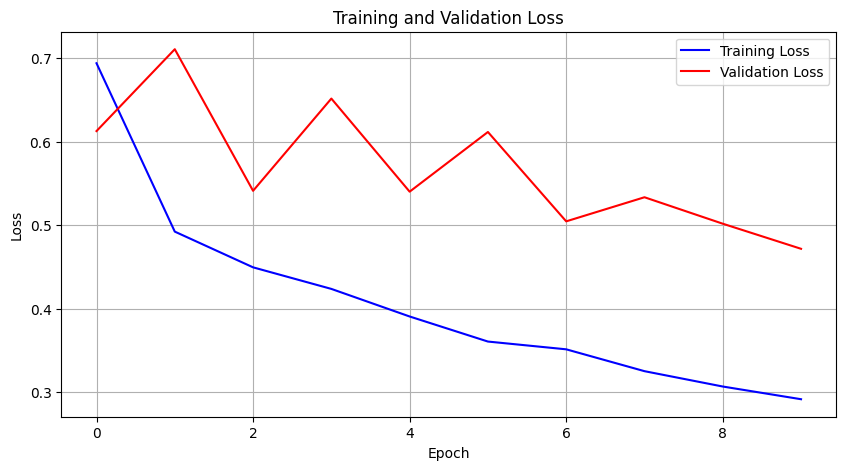

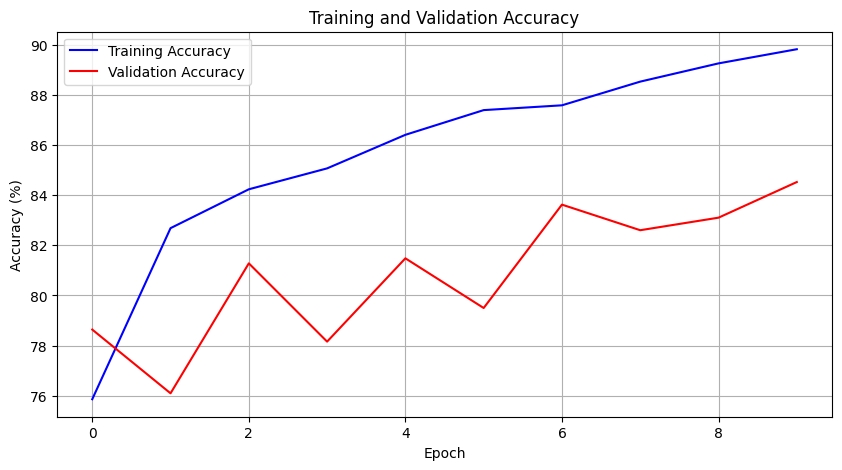

In [19]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Path where you want to save the combined weights
weights_save_path = "combined_block1_block2_block3_block4_block5_weights.pth"

# Create a dictionary to hold the state dictionaries of the layers
combined_weights = {}

# Populate the dictionary with the state dictionaries of the layers
combined_weights["conv1.weight"] = model.conv1.weight
combined_weights["conv1.bias"] = model.conv1.bias
combined_weights["bn1.weight"] = model.bn1.weight
combined_weights["bn1.bias"] = model.bn1.bias
combined_weights["bn1.running_mean"] = model.bn1.running_mean
combined_weights["bn1.running_var"] = model.bn1.running_var

combined_weights["conv2.weight"] = model.conv2.weight
combined_weights["conv2.bias"] = model.conv2.bias
combined_weights["bn2.weight"] = model.bn2.weight
combined_weights["bn2.bias"] = model.bn2.bias
combined_weights["bn2.running_mean"] = model.bn2.running_mean
combined_weights["bn2.running_var"] = model.bn2.running_var

combined_weights["conv3.weight"] = model.conv3.weight
combined_weights["conv3.bias"] = model.conv3.bias
combined_weights["bn3.weight"] = model.bn3.weight
combined_weights["bn3.bias"] = model.bn3.bias
combined_weights["bn3.running_mean"] = model.bn3.running_mean
combined_weights["bn3.running_var"] = model.bn3.running_var

combined_weights["conv4.weight"] = model.conv4.weight
combined_weights["conv4.bias"] = model.conv4.bias
combined_weights["bn4.weight"] = model.bn4.weight
combined_weights["bn4.bias"] = model.bn4.bias
combined_weights["bn4.running_mean"] = model.bn4.running_mean
combined_weights["bn4.running_var"] = model.bn4.running_var

combined_weights["conv4_1.weight"] = model.conv4_1.weight
combined_weights["conv4_1.bias"] = model.conv4_1.bias
combined_weights["bn4_1.weight"] = model.bn4_1.weight
combined_weights["bn4_1.bias"] = model.bn4_1.bias
combined_weights["bn4_1.running_mean"] = model.bn4_1.running_mean
combined_weights["bn4_1.running_var"] = model.bn4_1.running_var

# Save the combined weights to the specified path
torch.save(combined_weights, weights_save_path)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with all the blocks
class VGG11l6(nn.Module):
    def __init__(self):
        super(VGG11l6, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Adjusted input size based on output shape of block 6
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11l6().to(device)

# Path to the saved combined weights of Block 1 through Block 5
weights_path = "combined_block1_block2_block3_block4_block5_weights.pth"

# Load the combined weights into the model
model.load_state_dict(torch.load(weights_path), strict=False)

# Freeze Block 1 through Block 5
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True
for param in model.conv4.parameters():
    param.requires_grad = True
for param in model.conv4_1.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training Block 6 and FC layers
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [22]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.4498, Validation Loss: 0.5651, Validation Accuracy: 81.58%
Epoch 2/10, Train Loss: 0.3142, Validation Loss: 0.4924, Validation Accuracy: 83.82%
Epoch 3/10, Train Loss: 0.2918, Validation Loss: 0.5488, Validation Accuracy: 82.28%
Epoch 4/10, Train Loss: 0.2686, Validation Loss: 0.4944, Validation Accuracy: 84.18%
Epoch 5/10, Train Loss: 0.2514, Validation Loss: 0.4967, Validation Accuracy: 84.50%
Epoch 6/10, Train Loss: 0.2344, Validation Loss: 0.4506, Validation Accuracy: 85.54%
Epoch 7/10, Train Loss: 0.2271, Validation Loss: 0.5778, Validation Accuracy: 82.92%
Epoch 8/10, Train Loss: 0.2149, Validation Loss: 0.5571, Validation Accuracy: 83.00%
Epoch 9/10, Train Loss: 0.2013, Validation Loss: 0.5434, Validation Accuracy: 83.58%
Epoch 10/10, Train Loss: 0.1899, Validation Loss: 0.5683, Validation Accuracy: 83.50%


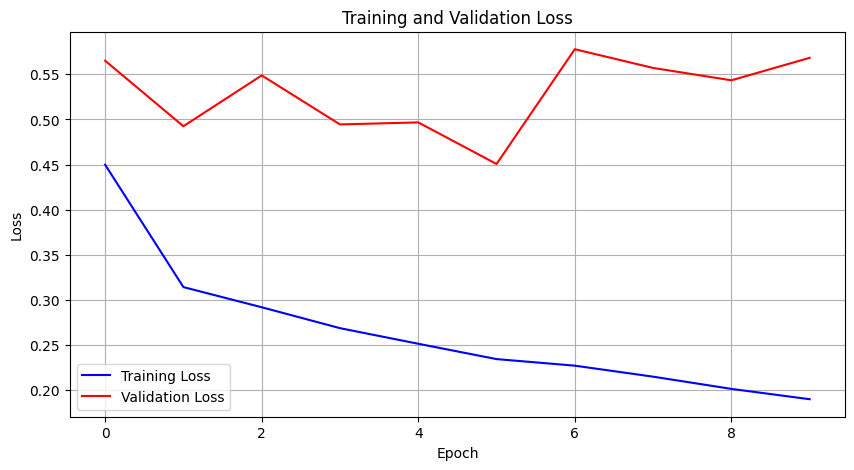

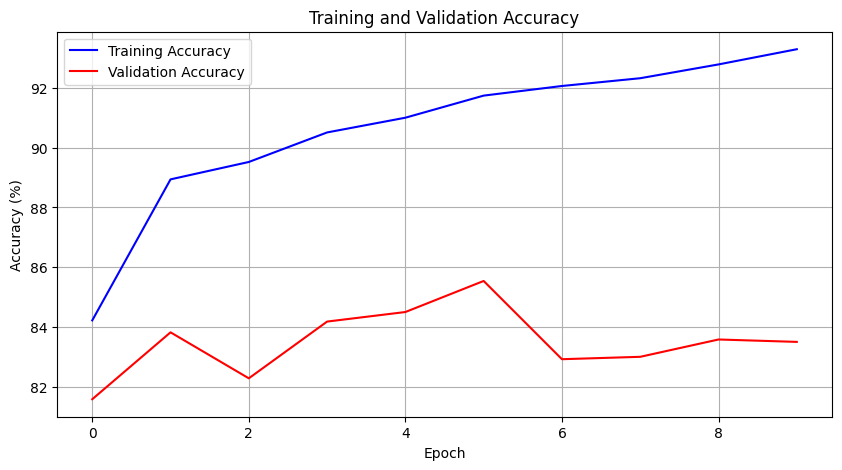

In [23]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Create a combined dictionary containing weights of Block 1 to Block 6
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var,

    # Block 5
    "conv4_1.weight": model.conv4_1.weight,
    "conv4_1.bias": model.conv4_1.bias,
    "bn4_1.weight": model.bn4_1.weight,
    "bn4_1.bias": model.bn4_1.bias,
    "bn4_1.running_mean": model.bn4_1.running_mean,
    "bn4_1.running_var": model.bn4_1.running_var,

    # Block 6
    "conv4_2.weight": model.conv4_2.weight,
    "conv4_2.bias": model.conv4_2.bias,
    "bn4_2.weight": model.bn4_2.weight,
    "bn4_2.bias": model.bn4_2.bias,
    "bn4_2.running_mean": model.bn4_2.running_mean,
    "bn4_2.running_var": model.bn4_2.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, "combined_block1_block2_block3_block4_block5_block6_weights.pth")


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with all the blocks
class VGG11l7(nn.Module):
    def __init__(self):
        super(VGG11l7, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 7
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.relu5_1 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Block 7
        x = self.relu5_1(self.bn5_1(self.conv5_1(x)))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11l7().to(device)
# Path to the saved combined weights of Block 1 to Block 6
weights_path = "combined_block1_block2_block3_block4_block5_block6_weights.pth"

# Load the combined weights into the model
combined_weights = torch.load(weights_path)
model.load_state_dict(combined_weights, strict=False)

# Freeze Block 1 to Block 6
for param in model.parameters():
    param.requires_grad = True

# Allow Block 7 and the fully connected layers to be trained
for param in model.conv5_1.parameters():
    param.requires_grad = True
for param in model.bn5_1.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Define optimizer and criterion for Block 7 and the fully connected layers
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()



In [26]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.2675, Validation Loss: 0.6416, Validation Accuracy: 81.22%
Epoch 2/10, Train Loss: 0.1812, Validation Loss: 0.5334, Validation Accuracy: 84.86%
Epoch 3/10, Train Loss: 0.1726, Validation Loss: 0.6471, Validation Accuracy: 82.58%
Epoch 4/10, Train Loss: 0.1698, Validation Loss: 0.5934, Validation Accuracy: 82.50%
Epoch 5/10, Train Loss: 0.1588, Validation Loss: 0.4880, Validation Accuracy: 85.92%
Epoch 6/10, Train Loss: 0.1468, Validation Loss: 0.5304, Validation Accuracy: 85.00%
Epoch 7/10, Train Loss: 0.1400, Validation Loss: 0.6488, Validation Accuracy: 83.16%
Epoch 8/10, Train Loss: 0.1392, Validation Loss: 0.5206, Validation Accuracy: 84.54%
Epoch 9/10, Train Loss: 0.1296, Validation Loss: 0.5946, Validation Accuracy: 83.88%
Epoch 10/10, Train Loss: 0.1275, Validation Loss: 0.5237, Validation Accuracy: 86.26%


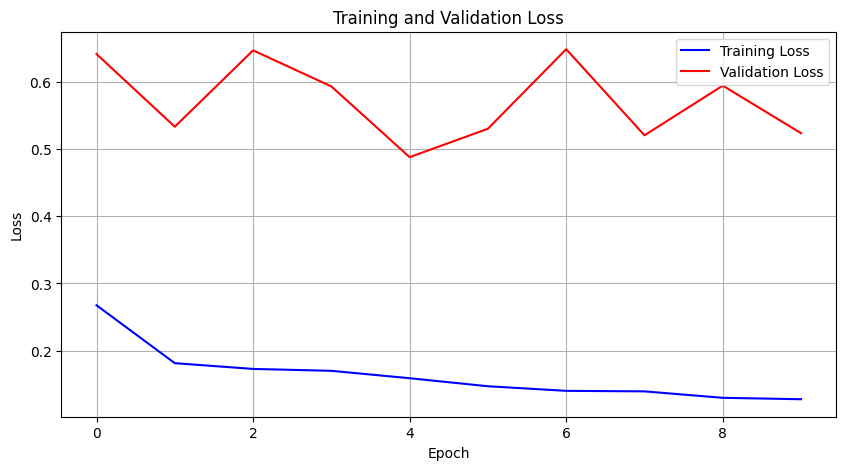

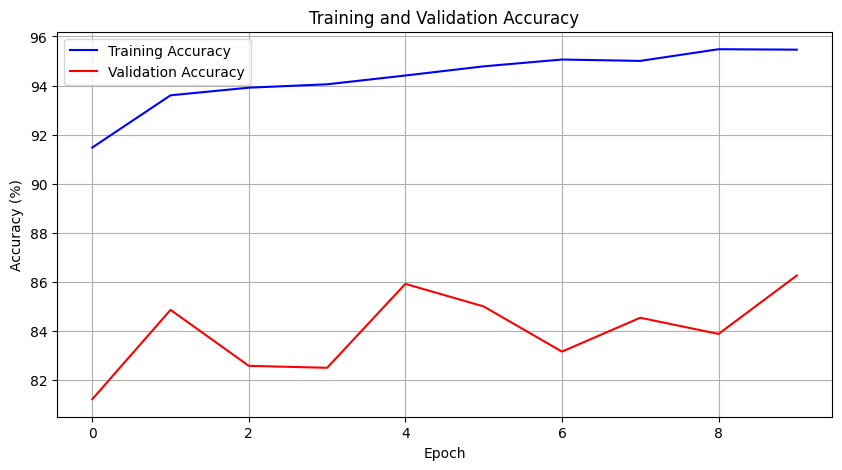

In [27]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Define the path to save the combined weights of Block 1 to Block 7
combined_weights_path = "combined_block1_block2_block3_block4_block5_block6_block7_weights.pth"

# Create a dictionary to hold the weights of all the blocks
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var,

    # Block 5
    "conv4_1.weight": model.conv4_1.weight,
    "conv4_1.bias": model.conv4_1.bias,
    "bn4_1.weight": model.bn4_1.weight,
    "bn4_1.bias": model.bn4_1.bias,
    "bn4_1.running_mean": model.bn4_1.running_mean,
    "bn4_1.running_var": model.bn4_1.running_var,

    # Block 6
    "conv4_2.weight": model.conv4_2.weight,
    "conv4_2.bias": model.conv4_2.bias,
    "bn4_2.weight": model.bn4_2.weight,
    "bn4_2.bias": model.bn4_2.bias,
    "bn4_2.running_mean": model.bn4_2.running_mean,
    "bn4_2.running_var": model.bn4_2.running_var,

    # Block 7
    "conv5_1.weight": model.conv5_1.weight,
    "conv5_1.bias": model.conv5_1.bias,
    "bn5_1.weight": model.bn5_1.weight,
    "bn5_1.bias": model.bn5_1.bias,
    "bn5_1.running_mean": model.bn5_1.running_mean,
    "bn5_1.running_var": model.bn5_1.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, combined_weights_path)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with Block 8
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 7
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.relu5_1 = nn.ReLU(inplace=True)

        # Block 8
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 1 * 1, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Block 7
        x = self.relu5_1(self.bn5_1(self.conv5_1(x)))

        # Block 8
        x = self.maxpool5(self.relu8(self.bn8(self.conv8(x))))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model

model = VGG11().to(device)
# Path to the saved combined weights of Block 1 to Block 7
weights_path = "combined_block1_block2_block3_block4_block5_block6_block7_weights.pth"

# Load the combined weights into the model
model.load_state_dict(torch.load(weights_path), strict=False)

# Freeze Block 1 to Block 7
for param in model.parameters():
    param.requires_grad = True

# Allow Block 8 and fully connected layers to be trainable
for param in model.conv8.parameters():
    param.requires_grad = True
for param in model.bn8.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [30]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.1595, Validation Loss: 0.7147, Validation Accuracy: 81.60%
Epoch 2/10, Train Loss: 0.1265, Validation Loss: 0.5688, Validation Accuracy: 84.08%
Epoch 3/10, Train Loss: 0.1195, Validation Loss: 0.5339, Validation Accuracy: 85.60%
Epoch 4/10, Train Loss: 0.1129, Validation Loss: 0.5507, Validation Accuracy: 84.88%
Epoch 5/10, Train Loss: 0.1071, Validation Loss: 0.6313, Validation Accuracy: 83.48%
Epoch 6/10, Train Loss: 0.1137, Validation Loss: 0.6828, Validation Accuracy: 82.46%
Epoch 7/10, Train Loss: 0.1042, Validation Loss: 0.5973, Validation Accuracy: 84.70%
Epoch 8/10, Train Loss: 0.0944, Validation Loss: 0.5449, Validation Accuracy: 86.12%
Epoch 9/10, Train Loss: 0.0964, Validation Loss: 0.5877, Validation Accuracy: 84.80%
Epoch 10/10, Train Loss: 0.0934, Validation Loss: 0.6616, Validation Accuracy: 84.18%


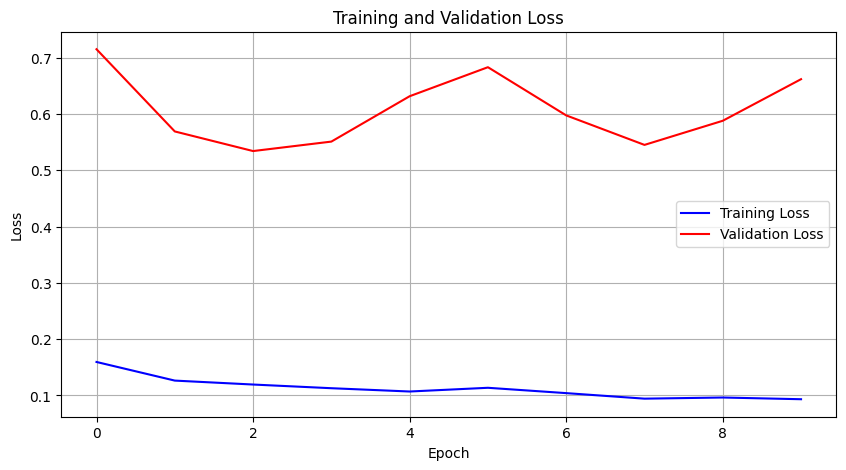

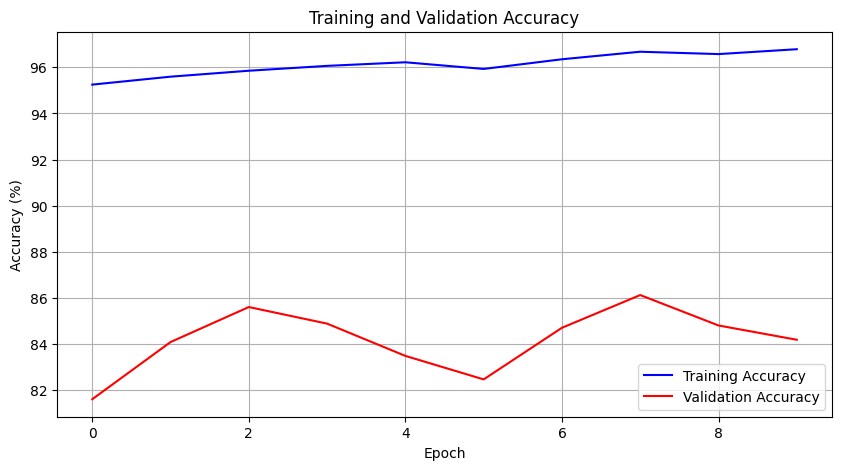

In [31]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

#Test dataset

In [32]:
# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Get predicted labels
        _, predicted = outputs.max(1)

        # Update total and correct predictions
        total_test += targets.size(0)
        correct_test += predicted.eq(targets).sum().item()

        # Save predictions and true labels for further analysis if needed
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)

# Calculate test accuracy
test_accuracy = 100. * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6568
Test Accuracy: 85.56%
